
# CSV Signal Backtest — **Isolated ₹50,000 per Trade** (No Capital Mixing)

This notebook runs a **simple swing backtest** directly on a CSV of pre-computed signals
(e.g., from your TA-Lib scanner). **Each row is treated as an independent trade with ₹50,000 capital.**
There is **no compounding** or shared equity — results are per-trade and then summarized.

**Default rules (long-only, configurable):**
- **Entry:** Next trading day **breakout above** `entry_suggest` (or `High × (1 + buffer)` if missing). Entry = `max(Open, trigger)` to handle gaps.
- **Stop:** `stop_suggest` from CSV (or `min(Low, Close) − ATR×mult` if missing).
- **Target:** **2R** (twice the initial risk per share).
- **Time stop:** Exit on **Close after 15 bars** if neither TP nor SL hit.
- **Costs:** Slippage **5 bps** each side; Fees **0.03%** each side.
- **Sizing:** By default **ALL-IN** with ₹50,000 per trade (integer shares). Optionally switch to **1% risk sizing** of the 50K.
- **Shorts:** Off by default. Enable if your CSV contains bearish signals you want to test.

> The goal is to evaluate the **quality of signals** when traded independently with a fixed budget per position.



## 0) Setup
Run once to ensure dependencies are present.


In [1]:

# %pip install yfinance pandas numpy matplotlib --quiet

import warnings
warnings.filterwarnings("ignore")

import os, json
import numpy as np
import pandas as pd
import datetime as dt

try:
    import yfinance as yf
except Exception as e:
    print("[WARN] yfinance missing. Install via: pip install yfinance")
    raise

import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)



## 1) Parameters
- **CSV_PATH**: path to your signals CSV.
- **ISOLATED_CAPITAL**: ₹50,000 per trade.
- **SIZING_MODE**: `"all_in"` or `"risk_1pct"` (1% of 50K per trade using `risk_per_share` if present).


In [2]:

# ===== User Parameters =====
CSV_PATH = "confirmed_candlestick_signals_talib_v4_extras.csv"  # uploaded from chat
DATE_COL = "date"        # will auto-detect if missing
TICKER_COL = "ticker"    # will auto-detect if missing

ISOLATED_CAPITAL = 50_000.0
SIZING_MODE = "all_in"        # "all_in" or "risk_1pct"
RISK_PCT = 0.01               # used only if SIZING_MODE = "risk_1pct"

# Backtest behavior
ENTRY_BUFFER_PCT = 0.003  # used if CSV lacks "entry_suggest"
ATR_LEN = 14              # only for fallback stop calc if needed
STOP_ATR_MULT = 1.2       # used if CSV lacks "stop_suggest"
MAX_HOLD_BARS = 20
R_MULT_TARGET = 2.0
SLIPPAGE_BPS  = 5           # 0.05% per side
FEES_PCT      = 0.0003      # 0.03% per side
ALLOW_SHORTS  = False

# Outputs
OUT_TRADES = "isolated50k_trades.csv"
OUT_SUMMARY_JSON = "isolated50k_summary.json"



## 2) Load CSV and auto-detect columns
The script expects (at minimum): `ticker`, `date`. It uses, if available:
`entry_suggest`, `stop_suggest`, `high`, `low`, `close`, `atr14`, `direction`.


In [3]:

def _find_col(df: pd.DataFrame, candidates):
    for c in candidates:
        if c in df.columns:
            return c
        for col in df.columns:
            if col.lower() == c.lower():
                return col
    return None

if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV not found at {CSV_PATH}")

sig = pd.read_csv(CSV_PATH)
print("Loaded CSV:", CSV_PATH, "shape:", sig.shape)

# Auto-detect columns
ticker_col = _find_col(sig, [TICKER_COL, "symbol", "scrip", "code", "Ticker"])
date_col   = _find_col(sig, [DATE_COL, "timestamp", "dt", "signal_date", "Date"])

if ticker_col is None or date_col is None:
    raise ValueError(f"Could not find required columns. Found ticker_col={ticker_col}, date_col={date_col}")

sig[date_col] = pd.to_datetime(sig[date_col]).dt.normalize()
sig = sig.dropna(subset=[ticker_col, date_col]).copy()

# Optional fields
entry_col = _find_col(sig, ["entry_suggest", "entry", "trigger"])
stop_col  = _find_col(sig, ["stop_suggest", "stop"])
high_col  = _find_col(sig, ["high", "High"])
low_col   = _find_col(sig, ["low", "Low"])
close_col = _find_col(sig, ["close", "Close"])
atr_col   = _find_col(sig, ["atr14", "ATR", "atr"])
dir_col   = _find_col(sig, ["direction", "side"])

print("Cols ->", dict(ticker=ticker_col, date=date_col, entry=entry_col, stop=stop_col, high=high_col, low=low_col, close=close_col, atr=atr_col, direction=dir_col))

# Basic clean and sort
sig = sig.sort_values([date_col, ticker_col]).reset_index(drop=True)
display(sig.head(10))


Loaded CSV: confirmed_candlestick_signals_talib_v4_extras.csv shape: (116218, 41)
Cols -> {'ticker': 'ticker', 'date': 'date', 'entry': 'entry_suggest', 'stop': 'stop_suggest', 'high': 'high', 'low': 'low', 'close': 'close', 'atr': 'atr14', 'direction': 'direction'}


,ticker,date,pattern,direction,open,high,low,close,rsi14,macd,macd_signal,macd_hist,sto_k,sto_d,adx,di_plus,di_minus,aroon_up,aroon_dn,aroon_osc,bb_upper,bb_mid,bb_lower,bb_width,pct_b,bb_squeeze,atr14,vol,vol20,obv,obv_slope,eom14,sma50,sma200,confirmations_met,num_conf,entry_suggest,stop_suggest,risk_per_share,size_for_1pct,note
0,BIOCON.NS,2018-01-29,CDLDOJI,bullish,306.5000,320.9500,304.5000,307.7250,65.73,NaN,NaN,NaN,71.00,79.37,NaN,38.54,12.33,NaN,NaN,NaN,316.5895,281.8137,247.0380,0.246799,0.8725,False,11.7740,11886780,6304169,41088984,11886780,NaN,NaN,NaN,"RSI>50,BB_conf,Vol≥1.5x20d,OBV↑",4,321.9129,290.3712,31.5417,31,Buy on breakout > pattern High (+buffer)
1,UPL.NS,2018-01-29,CDLHARAMI,bullish,518.6334,530.2667,514.6667,525.6667,54.96,NaN,NaN,NaN,52.99,68.70,NaN,17.20,21.83,NaN,NaN,NaN,545.5437,523.4517,501.3597,0.084409,0.5501,False,15.2926,8319201,3092084,20642277,8319201,NaN,NaN,NaN,"RSI>50,BB_conf,Vol≥1.5x20d,OBV↑",4,531.8575,496.3156,35.5419,28,Buy on breakout > pattern High (+buffer)
2,BPCL.NS,2018-01-30,CDLENGULFING,bullish,234.6000,246.3000,234.4750,242.8000,43.10,NaN,NaN,NaN,39.02,38.09,NaN,14.67,22.61,NaN,NaN,NaN,251.7784,242.6175,233.4566,0.075517,0.5100,False,5.8635,13185108,7106209,-31502426,13185108,NaN,NaN,NaN,"STO_K>D & >20,BB_conf,Vol≥1.5x20d,OBV↑",4,247.0389,227.4388,19.6001,51,Buy on breakout > pattern High (+buffer)
3,BSOFT.NS,2018-01-30,CDLENGULFING,bullish,124.9480,138.8726,124.4818,136.3550,72.66,NaN,NaN,NaN,84.12,83.00,NaN,28.57,10.39,NaN,NaN,NaN,134.1935,126.1757,118.1580,0.127089,1.1348,False,6.1327,24636830,5912685,67035857,24636830,NaN,NaN,NaN,"RSI>50,BB_conf,Vol≥1.5x20d,OBV↑",4,139.2892,117.1226,22.1666,45,Buy on breakout > pattern High (+buffer)
4,FACT.NS,2018-01-30,CDLHARAMI,bullish,61.4500,64.2000,58.1500,61.9500,63.89,NaN,NaN,NaN,73.91,52.54,NaN,32.04,16.78,NaN,NaN,NaN,61.8195,57.2000,52.5805,0.161522,1.0141,False,3.7447,727091,470207,4124653,727091,NaN,NaN,NaN,"RSI>50,BB_conf,Vol≥1.5x20d,OBV↑",4,64.3926,53.6563,10.7363,93,Buy on breakout > pattern High (+buffer)
5,JMFINANCIL.NS,2018-01-30,CDLENGULFING,bullish,160.2000,162.7500,156.7500,162.0500,53.52,NaN,NaN,NaN,31.15,27.15,NaN,12.82,16.13,NaN,NaN,NaN,170.0172,162.0400,154.0628,0.098460,0.5006,False,6.3517,1331154,1241996,6010469,1331154,NaN,NaN,NaN,"RSI>50,STO_K>D & >20,BB_conf,OBV↑",4,163.2382,149.1279,14.1103,70,Buy on breakout > pattern High (+buffer)
6,M&M.NS,2018-01-30,CDLDOJI,bullish,764.0000,768.6500,753.1000,764.9000,59.31,NaN,NaN,NaN,63.86,59.54,NaN,18.66,14.65,NaN,NaN,NaN,771.5968,759.1750,746.7532,0.032725,0.7304,False,13.5345,1648188,2013540,22804954,1648188,NaN,NaN,NaN,"RSI>50,STO_K>D & >20,BB_conf,OBV↑",4,770.9560,736.8586,34.0974,29,Buy on breakout > pattern High (+buffer)
7,APLLTD.NS,2018-01-31,CDLENGULFING,bullish,543.5000,576.9000,543.5000,567.1000,64.84,NaN,NaN,NaN,64.07,58.37,NaN,29.95,13.32,NaN,NaN,NaN,573.6659,548.3700,523.0741,0.092259,0.8702,False,17.6147,488735,124183,659136,488735,NaN,NaN,NaN,"RSI>50,BB_conf,Vol≥1.5x20d,OBV↑",4,578.6307,522.3623,56.2684,17,Buy on breakout > pattern High (+buffer)
8,FINCABLES.NS,2018-01-31,CDLDOJI,bullish,734.8000,744.0000,720.0500,735.0500,58.12,NaN,NaN,NaN,59.69,56.79,NaN,19.69,13.09,NaN,NaN,NaN,750.9597,722.9800,695.0003,0.077401,0.7157,False,21.6362,63825,41526,193373,63825,NaN,NaN,NaN,"RSI>50,STO_K>D & >20,BB_conf,Vol≥1.5x20d,OBV↑",5,746.2320,694.0866,52.1454,19,Buy on breakout > pattern High (+buffer)
9,PRESTIGE.NS,2018-01-31,CDLENGULFING,bullish,315.9000,325.0000,314.8000,322.8000,55.26,NaN,NaN,NaN,29.48,25.88,NaN,22.24,10.56,NaN,NaN,NaN,347.7289,325.7475,303.7661,0.134960,0.4330,False,14.5271,1551929,493483,4189410,1551929,NaN,NaN,NaN,"RSI>50,STO_K>D & >20,Vol≥1.5x20d,OBV↑",4,325.9750,297.3674,28.6076,34,Buy on breakout > pattern High (+buffer)



## 3) Download daily OHLCV for the involved tickers
We fetch data slightly before/after the signal date range to ensure enough bars for entries and exits.


In [4]:

tickers = sorted(sig[ticker_col].unique().tolist())
start_pad = sig[date_col].min() - pd.Timedelta(days=40)
end_pad   = sig[date_col].max() + pd.Timedelta(days=60)

print(f"Downloading OHLCV for {len(tickers)} tickers from {start_pad.date()} to {end_pad.date()} ...")
prices_map = {}
for t in tickers:
    try:
        df = yf.download(t, start=start_pad.date().isoformat(), end=end_pad.date().isoformat(),
                         interval="1d", progress=False, auto_adjust=False)
        if df.empty:
            print(f"[WARN] No data for {t}")
            continue
        df.index = pd.to_datetime(df.index).tz_localize(None).normalize()
        prices_map[t] = df
    except Exception as e:
        print(f"[WARN] Failed {t}: {e}")

print("Have data for:", len(prices_map), "tickers.")


Have data for: 499 tickers.



## 4) Backtest engine (isolated ₹50k per trade)
- Each row creates its **own trade** that does **not** affect any other trade.
- Sizing: **ALL-IN** on 50k (default) or **1% risk** of 50k if `SIZING_MODE="risk_1pct"`.


In [5]:

from typing import Tuple

def _bps_to_pct(bps: float) -> float:
    return bps / 10_000.0

def _ensure_signal_in_index(df: pd.DataFrame, d: pd.Timestamp) -> pd.Timestamp:
    d = pd.to_datetime(d).normalize()
    if d in df.index:
        return d
    idx = df.index.searchsorted(d, side="left")
    if idx >= len(df.index):
        return None
    return df.index[idx]

def _fallback_entry_stop(row):
    # entry fallback: High * (1 + buffer)
    # stop fallback: min(Low, Close) - ATR*mult (if ATR exists)
    trig = None
    stp  = None
    if pd.notna(row.get("High", np.nan)):
        trig = float(row["High"]) * (1 + ENTRY_BUFFER_PCT)
    if pd.notna(row.get("Low", np.nan)) and pd.notna(row.get("Close", np.nan)):
        atr = float(row.get("atr14", row.get("ATR", 0)) or 0)
        stp = float(min(row["Low"], row["Close"])) - STOP_ATR_MULT * atr
    return trig, stp

def backtest_isolated(csv_df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    slip = _bps_to_pct(SLIPPAGE_BPS)

    for i, r in csv_df.iterrows():
        t = r[ticker_col]
        d = r[date_col]

        if dir_col and pd.notna(r.get(dir_col)) and str(r[dir_col]).lower().startswith("bear") and not ALLOW_SHORTS:
            # Skip shorts if not allowed
            continue

        px = prices_map.get(t)
        if px is None or px.empty:
            rows.append({"ticker": t, "signal_date": d.date(), "outcome": "NODATA"})
            continue

        sig_d = _ensure_signal_in_index(px, d)
        if sig_d is None or sig_d not in px.index:
            rows.append({"ticker": t, "signal_date": d.date(), "outcome": "NOTRADEDAY"})
            continue

        idx = px.index.get_loc(sig_d)
        if idx + 1 >= len(px.index):
            rows.append({"ticker": t, "signal_date": d.date(), "outcome": "NOFUTUREBAR"})
            continue

        # Determine trigger & stop
        trigger = float(r[entry_col]) if entry_col and pd.notna(r.get(entry_col)) else None
        stop_init = float(r[stop_col]) if stop_col and pd.notna(r.get(stop_col)) else None

        if trigger is None or stop_init is None:
            # Try fallback using high/low/close/atr
            hlc = {
                "High": r.get(high_col) if high_col else np.nan,
                "Low": r.get(low_col) if low_col else np.nan,
                "Close": r.get(close_col) if close_col else np.nan,
                "atr14": r.get(atr_col) if atr_col else np.nan,
            }
            trig_fb, stp_fb = _fallback_entry_stop(hlc)
            trigger = trigger if trigger is not None else trig_fb
            stop_init = stop_init if stop_init is not None else stp_fb

        if trigger is None or stop_init is None or not np.isfinite(trigger) or not np.isfinite(stop_init):
            rows.append({"ticker": t, "signal_date": d.date(), "outcome": "MISSING_TRIGGER_STOP"})
            continue

        # Search for breakout and enter
        entry_date = None
        entry_price = None
        for fwd in range(1, MAX_HOLD_BARS+1):
            if idx + fwd >= len(px.index):
                break
            day = px.index[idx+fwd]
            op, hi = float(px.loc[day, "Open"]), float(px.loc[day, "High"])
            if hi >= trigger:
                entry_date = day
                entry_price = max(op, trigger)
                break

        if entry_date is None:
            rows.append({
                "ticker": t, "signal_date": d.date(), "pattern": r.get("pattern", np.nan),
                "entry_date": None, "exit_date": None, "entry": np.nan, "exit": np.nan,
                "stop": round(stop_init, 4), "target": np.nan, "bars_in_trade": 0,
                "shares": 0, "pnl": 0.0, "ret_pct_on_50k": 0.0, "R": 0.0, "outcome": "NOENTRY"
            })
            continue

        risk_ps = abs(entry_price - stop_init)
        if not np.isfinite(risk_ps) or risk_ps <= 0:
            rows.append({
                "ticker": t, "signal_date": d.date(), "pattern": r.get("pattern", np.nan),
                "entry_date": entry_date.date(), "exit_date": entry_date.date(),
                "entry": round(entry_price,4), "exit": round(entry_price,4),
                "stop": round(stop_init,4), "target": np.nan, "bars_in_trade": 0,
                "shares": 0, "pnl": 0.0, "ret_pct_on_50k": 0.0, "R": 0.0, "outcome": "INVALID_RISK"
            })
            continue

        target = entry_price + R_MULT_TARGET * risk_ps

        # Sizing
        if SIZING_MODE == "all_in":
            entry_eff = entry_price * (1 + slip)  # include slippage on buy
            shares = int(ISOLATED_CAPITAL // entry_eff)
            if shares <= 0:
                shares = 0
        else:  # risk_1pct
            rps = float(r.get("risk_per_share", np.nan)) if "risk_per_share" in r.index else risk_ps
            if not np.isfinite(rps) or rps <= 0:
                rps = risk_ps
            shares = int((ISOLATED_CAPITAL * RISK_PCT) // rps)
            if shares <= 0:
                shares = 0

        if shares <= 0:
            rows.append({
                "ticker": t, "signal_date": d.date(), "pattern": r.get("pattern", np.nan),
                "entry_date": entry_date.date(), "exit_date": entry_date.date(),
                "entry": round(entry_price,4), "exit": round(entry_price,4),
                "stop": round(stop_init,4), "target": round(target,4), "bars_in_trade": 0,
                "shares": 0, "pnl": 0.0, "ret_pct_on_50k": 0.0, "R": 0.0, "outcome": "NOSIZE"
            })
            continue

        # Walk forward to exit
        eidx = px.index.get_loc(entry_date)
        exit_price = None
        exit_date = None
        outcome = None
        bars_in_trade = 0

        for fwd in range(0, MAX_HOLD_BARS):
            if eidx + fwd >= len(px.index):
                break
            day = px.index[eidx + fwd]
            op, hi, lo, cl = float(px.loc[day,"Open"]), float(px.loc[day,"High"]), float(px.loc[day,"Low"]), float(px.loc[day,"Close"])
            bars_in_trade = fwd + 1

            # 1) Gap stop
            if day == entry_date and op < stop_init:
                exit_price = op
                exit_date = day
                outcome = "SL(gap)"
                break
            # 2) In-bar SL then TP
            if lo <= stop_init:
                exit_price = min(stop_init, op) if op < stop_init else stop_init
                exit_date = day
                outcome = "SL"
                break
            if hi >= target:
                exit_price = max(target, op) if op > target else target
                exit_date = day
                outcome = "TP"
                break

            if fwd == MAX_HOLD_BARS - 1:
                exit_price = cl
                exit_date = day
                outcome = "TIME"
                break

        if exit_price is None or exit_date is None:
            # force exit on last close in window
            last_i = min(eidx + MAX_HOLD_BARS - 1, len(px.index)-1)
            if last_i < eidx:
                last_i = eidx
            exit_date = px.index[last_i]
            exit_price = float(px.loc[exit_date,"Close"])
            outcome = "EOD"

        # P&L with costs
        entry_eff = entry_price * (1 + slip)   # buy
        exit_eff  = exit_price  * (1 - slip)   # sell
        fees_amt  = (entry_eff + exit_eff) * shares * FEES_PCT
        pnl = (exit_eff - entry_eff) * shares - fees_amt
        R = (exit_price - entry_price) / risk_ps if risk_ps > 0 else 0.0
        ret_pct_on_cap = (pnl / ISOLATED_CAPITAL) * 100.0

        rows.append({
            "ticker": t, "signal_date": d.date(), "pattern": r.get("pattern", np.nan),
            "entry_date": entry_date.date(), "exit_date": exit_date.date(),
            "entry": round(entry_price,4), "exit": round(exit_price,4),
            "stop": round(stop_init,4), "target": round(target,4), "bars_in_trade": bars_in_trade,
            "shares": int(shares), "pnl": round(pnl,2), "ret_pct_on_50k": round(ret_pct_on_cap,3), "R": round(R,3),
            "outcome": outcome
        })

    return pd.DataFrame(rows)



## 5) Run backtest and export results
- Exports a full trade ledger to CSV.
- Prints summary metrics and saves them to JSON.


In [6]:

trades = backtest_isolated(sig)
print("Trades:", len(trades))
display(trades.head(20))

# Save trades
trades.to_csv(OUT_TRADES, index=False)
print("Saved trades ->", OUT_TRADES)

# Summary metrics
valid = trades[trades["outcome"].isin(["TP","SL","TIME","SL(gap)","EOD"])]
num = int(len(valid))
wins = int((valid["outcome"] == "TP").sum())
hit_rate = (wins / num * 100.0) if num > 0 else 0.0
total_pnl = float(trades["pnl"].sum())
avg_ret = float(valid["ret_pct_on_50k"].mean()) if num > 0 else 0.0
med_ret = float(valid["ret_pct_on_50k"].median()) if num > 0 else 0.0
avg_R = float(valid["R"].mean()) if num > 0 else 0.0

by_pattern = trades.groupby("pattern")["pnl"].agg(["count","sum","mean"]).reset_index().sort_values("sum", ascending=False)

summary = {
    "num_signals": int(len(trades)),
    "num_trades_evaluated": num,
    "wins": wins,
    "hit_rate_pct": round(hit_rate, 2),
    "total_pnl": round(total_pnl, 2),
    "avg_return_pct_on_50k": round(avg_ret, 3),
    "median_return_pct_on_50k": round(med_ret, 3),
    "avg_R": round(avg_R, 3),
}

print("Summary:")
import json; print(json.dumps(summary, indent=2))

# Save summary JSON
with open(OUT_SUMMARY_JSON, "w") as f:
    json.dump(summary, f, indent=2)

display(by_pattern.head(10))


Trades: 116218


,ticker,signal_date,pattern,entry_date,exit_date,entry,exit,stop,target,bars_in_trade,shares,pnl,ret_pct_on_50k,R,outcome
0,BIOCON.NS,2018-01-29,CDLDOJI,None,None,NaN,NaN,290.3712,NaN,0,0,0.00,0.000,0.000,NOENTRY
1,UPL.NS,2018-01-29,CDLHARAMI,None,None,NaN,NaN,496.3156,NaN,0,0,0.00,0.000,0.000,NOENTRY
2,BPCL.NS,2018-01-30,CDLENGULFING,None,None,NaN,NaN,227.4388,NaN,0,0,0.00,0.000,0.000,NOENTRY
3,BSOFT.NS,2018-01-30,CDLENGULFING,2018-02-08,2018-03-09,139.2892,130.6359,117.1226,183.6224,20,358,-3175.17,-6.350,-0.390,TIME
4,FACT.NS,2018-01-30,CDLHARAMI,2018-02-01,2018-02-02,64.3926,53.6563,53.6563,85.8652,2,776,-8404.65,-16.809,-1.000,SL
5,JMFINANCIL.NS,2018-01-30,CDLENGULFING,2018-01-31,2018-02-06,163.2382,147.0000,149.1279,191.4588,5,306,-5044.84,-10.090,-1.151,SL
6,M&M.NS,2018-01-30,CDLDOJI,2018-01-31,2018-02-06,770.9560,736.8586,736.8586,839.1508,5,64,-2259.43,-4.519,-1.000,SL
7,APLLTD.NS,2018-01-31,CDLENGULFING,2018-02-15,2018-03-09,578.6307,522.3623,522.3623,691.1675,16,86,-4914.83,-9.830,-1.000,SL
8,FINCABLES.NS,2018-01-31,CDLDOJI,2018-02-14,2018-02-22,746.2320,694.0866,694.0866,850.5228,7,66,-3517.65,-7.035,-1.000,SL
9,PRESTIGE.NS,2018-01-31,CDLENGULFING,2018-02-01,2018-02-06,325.9750,289.8000,297.3674,383.1902,4,153,-5610.15,-11.220,-1.265,SL


Saved trades -> isolated50k_trades.csv
Summary:
{
  "num_signals": 116218,
  "num_trades_evaluated": 103684,
  "wins": 23161,
  "hit_rate_pct": 22.34,
  "total_pnl": 52700365.74,
  "avg_return_pct_on_50k": 1.017,
  "median_return_pct_on_50k": -1.348,
  "avg_R": 0.157
}


,pattern,count,sum,mean
0,CDLDOJI,61797,29386533.60,475.533337
3,CDLHARAMI,20296,9449872.34,465.602697
1,CDLENGULFING,18465,8042441.57,435.550586
4,CDLHARAMICROSS,6961,2827292.14,406.161778
2,CDLHAMMER,3894,1016178.66,260.960108
5,CDLINVERTEDHAMMER,2319,882636.45,380.610802
6,CDLMORNINGSTAR,1690,715620.56,423.444118
7,CDLPIERCING,796,379790.42,477.123643



## 6) Optional: Visuals
A quick histogram of **per-trade returns (on ₹50k)** and a count by outcomes.


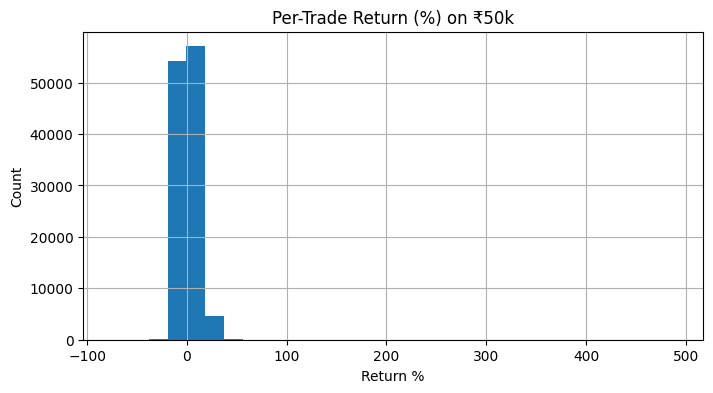

outcome
SL         41896
TIME       37484
TP         23161
NOENTRY    12308
EOD          758
SL(gap)      385
NOSIZE       226
Name: count, dtype: int64


In [7]:

if not trades.empty:
    # Histogram of per-trade returns
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,4))
    trades["ret_pct_on_50k"].hist(bins=30)
    plt.title("Per-Trade Return (%) on ₹50k")
    plt.xlabel("Return %"); plt.ylabel("Count")
    plt.show()

    # Outcome counts
    counts = trades["outcome"].value_counts()
    print(counts)
